### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../../src") if "../../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *

### Setup Experiment

In [3]:
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name = '3ME_large_batch', base_path=base_path)
experiment.setup()

Experiment <3ME_large_batch> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


False

In [4]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

device=device(type='cuda')


In [182]:
plt.rcParams.update({'figure.figsize': (3,3), 'figure.dpi': 150, 'legend.frameon': False})
# sns.set_style('white', {'legend.frameon': False})
palette = {'setosa': '#7fc97f', 'versicolor': '#beaed4', 'virginica': '#fdc086'}
palette2 = {0: '#e41a1c', 1: '#377eb8', 2: '#4daf4a'}
palette3 = {0: '#8dd3c7', 1: '#ffffb3', 2: '#bebada'}

def savefig(fname,filetype='svg'):
    plot_path = paths['experiment'] / 'plots'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
    plt.savefig(plot_path / f'{fname}.{filetype}', bbox_inches='tight', transparent=True)
    
def border_color(ax, color):
    return [spine.set_color(color) for spine in ax.spines.values()]

### Plot all place cell centers and some with tuning curves

In [96]:
def plot_env_and_pcs(pc_ensemble, color, fig=None, ax=None):
    x,y = pc_ensemble.pcs.T
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    ax.plot(x, y, "+", alpha=0.5, color='grey')
    # add standard deviation circles to locations
    for i in range(3):
        ax.text(x[i], y[i], f"{i}", color='black', ha='center', va='center')
        a_circle = plt.Circle((x[i], y[i]), pc_ensembles[0].pc_width, fill=False, color=color)
        ax.add_artist(a_circle)
        a_circle = plt.Circle((x[i], y[i]), 2*pc_ensembles[0].pc_width, fill=False, color=color)
        ax.add_artist(a_circle)
        

    #plt.title("Place cell placements")
    #plt.xlabel("X [m]")
    #plt.ylabel("Y [m]")
    #plt.locator_params(nbins=1)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    border_color(ax, color)
    return fig, ax

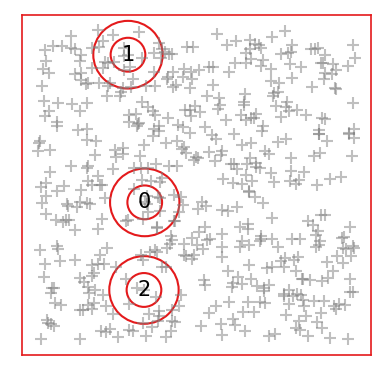

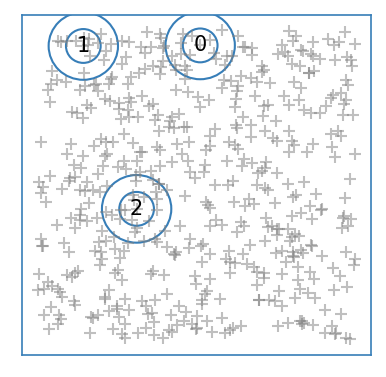

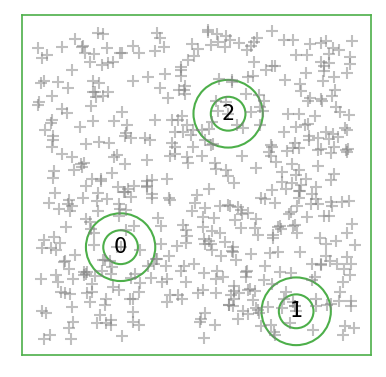

In [97]:
for env_i in range(len(environments)):
    plot_env_and_pcs(pc_ensembles[env_i], color=palette2[env_i])
    savefig(f'pcs_env_{env_i}')

## Create Place Cell Ratemap Plots

In [158]:
res = 128
pos = np.mgrid[0:res,0:res].T * environments[0].boxsize[0] / res

num_cells = 1
pc_responses = np.zeros((len(environments), res, res, num_cells))
for env_i in range(len(environments)):
    pc_responses[env_i] = pc_ensembles[env_i].softmax_response(torch.tensor(pos))[...,:num_cells].detach().numpy()
    
pos.shape, pc_responses.shape

((128, 128, 2), (3, 128, 128, 1))

In [177]:
def plot_pc_ratemap(pos, pc_response):
    res = scipy.stats.binned_statistic_2d(pos[...,0].flatten(), pos[...,1].flatten(), pc_response.flatten(), bins=90)
    fig,ax = plt.subplots()
    im = plt.imshow(res.statistic.T, origin='lower')
    #plt.colorbar(im,fraction=0.046, pad=0.04)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    return fig,ax

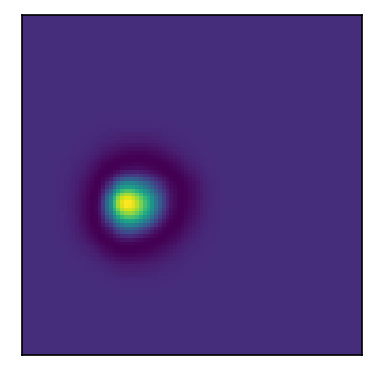

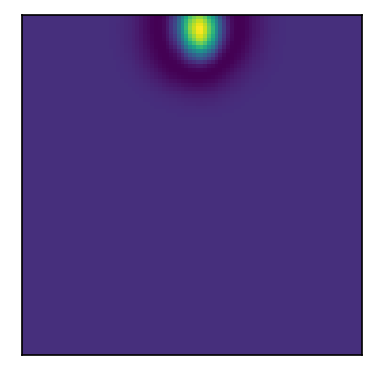

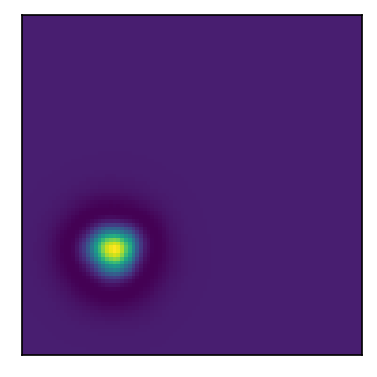

In [185]:
cell_num = 0
for env_i in range(len(environments)):
    fig,ax = plot_pc_ratemap(pos, pc_responses[env_i,...,cell_num])
    savefig(f'pc{cell_num}_env_{env_i}','pdf')

## Create Trajectory Example

In [203]:
agent.positions[0]

array([1.87617941, 2.0555889 ])

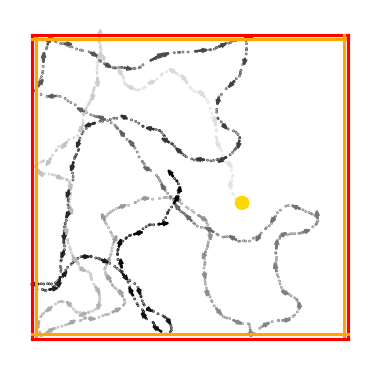

In [227]:
agent = agents[0]

agent.reset()
for _ in range(nsteps:=1000):
    agent.step()

# plot track
fig,axs=plt.subplots()
plt.axis('off')

# plot board and trajectory
environments[0].plot_board(axs)
agent.plot_trajectory(axs,ds=8)

a_circle = plt.Circle(agent.positions[0], 2.2*0.02, fill=True, color='gold')#, color=color)
axs.add_artist(a_circle)

savefig(f'trajectory_example','svg')